# Quadrotor Simulator

In order to easily simulate different algorithms, a simulation test bed must be created. This Python class deals with the plumbing between the controller, estimation, and the model of a quadrotor system. This notebook also provides abstract base classes for `Controller` and `Estimator`.

In [1]:
%%capture
# Load the quadrotor simulator from a previous notebook
%run quadrotor_model.ipynb

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Controller(object):
    """Controller
    """
    def __init__(self):
        self.name = "Manual"
    
    def __str__(self):
        return self.name
    
    def update(self, state, Ts):
        return np.array([[10, 0, 0, 0]]).T

In [4]:
class Estimator(object):
    """Estimator
    """
    def __init__(self):
        self.use_truth = True
        self.name = "Truth"
        
    def __str__(self):
        return self.name
    
    def update(self, Ts):
        pass

In [39]:
class Simulator(object):
    """Simulator
        
    This class deals with the high-level simulation plumbing for a quadrotor system
    """
    def __init__(self, quad=None, ctrl=None, estm=None):
        self.quad = quad if quad else Quadrotor()
        self.ctrl = ctrl if ctrl else Controller()
        self.estm = estm if estm else Estimator()
        
        # Keep a history for plotting
        self.hist = { 'u': None, 'state': None }
        
        # Simulation parameters
        self.Tf = 0
        self.Ts = 0
        self.N = 0
        
    def __str__(self):
        s  = "Simulation"
        return s
    
    def _step(self):
        pass
    
    def run(self, Tf, Ts=0.01):
        
        # save simulation parameters
        self.Tf = Tf
        self.Ts = Ts
        
        # How many iterations are needed
        self.N = int(Tf/Ts)
        
        # quadrotor state
        state = np.zeros((12,1))
        state[0:3] = self.quad.r
        state[3:6] = self.quad.v
        state[6:9] = self.quad.Phi
        state[9:12] = self.quad.omega
        
        # initialize the plot history
        self.hist['state'] = np.zeros((12,self.N))
#         from IPython.core.debugger import set_trace; set_trace()
        
        for i in range(self.N):
            # determine control
            u = self.ctrl.update(state, Ts)
                      
            # actuate physical model
            self.quad.update(u, Ts)
            
            # run estimator
            if self.estm.use_truth:
                state[0:3] = self.quad.r
                state[3:6] = self.quad.v
                state[6:9] = self.quad.Phi
                state[9:12] = self.quad.omega
            else:
                state = self.estm.update(Ts)
                
            # Update history
            self.hist['state'][:, i] = state.flatten()
    
    def plot(self):
        """Plot
        Create plot(s) of the evolution of the quadrotor state
        during the simulation horizon.
        """
        plt.ioff()
        fig = plt.figure(figsize=(12,10))
        fig.subplots_adjust(wspace=0.25)
        fig.suptitle('Vehicle State', fontsize=16)
        
        tvec = np.arange(self.N)*self.Ts
        
        #
        # Position
        #
        
        # for convenience
        xpos = self.hist['state'][0, :]
        ypos = self.hist['state'][1, :]
        zpos = self.hist['state'][2, :]
        
        ax = fig.add_subplot(6,2,1)
#         ax.plot(tvec, xpos, 'r-', label='command')
        ax.plot(tvec, xpos, 'b-', label='actual')
        ax.set_ylabel('x'); ax.grid()
        ax.legend()

        ax = fig.add_subplot(6,2,3)
#         ax.plot(tvec, ypos, 'r-', label='command')
        ax.plot(tvec, ypos, 'b-', label='actual')
        ax.set_ylabel('y'); ax.grid()
        
        ax = fig.add_subplot(6,2,5)
#         ax.plot(tvec, zpos, 'r-', label='command')
        ax.plot(tvec, zpos, 'b-', label='actual')
        ax.set_ylabel('z'); ax.grid()
        
        #
        # Velocity
        #
        
        # for convenience
        xvel = self.hist['state'][3, :]
        yvel = self.hist['state'][4, :]
        zvel = self.hist['state'][5, :]
        
        ax = fig.add_subplot(6,2,2)
#         ax.plot(tvec, xpos, 'r-', label='command')
        ax.plot(tvec, xvel, 'b-', label='actual')
        ax.set_ylabel('vx'); ax.grid()
#         ax.legend()

        ax = fig.add_subplot(6,2,4)
#         ax.plot(tvec, ypos, 'r-', label='command')
        ax.plot(tvec, yvel, 'b-', label='actual')
        ax.set_ylabel('vy'); ax.grid()
        
        ax = fig.add_subplot(6,2,6)
#         ax.plot(tvec, zpos, 'r-', label='command')
        ax.plot(tvec, zvel, 'b-', label='actual')
        ax.set_ylabel('vz'); ax.grid()
        
        #
        # Attitude
        #
        
        # for convenience
        ph = self.hist['state'][6, :]
        th = self.hist['state'][7, :]
        ps = self.hist['state'][8, :]
        
        ax = fig.add_subplot(6,2,7)
#         ax.plot(tvec, xpos, 'r-', label='command')
        ax.plot(tvec, np.degrees(ph), 'b-', label='actual')
        ax.set_ylabel(r'$\phi$'); ax.grid()

        ax = fig.add_subplot(6,2,9)
#         ax.plot(tvec, ypos, 'r-', label='command')
        ax.plot(tvec, np.degrees(th), 'b-', label='actual')
        ax.set_ylabel(r'$\theta$'); ax.grid()
        
        ax = fig.add_subplot(6,2,11)
#         ax.plot(tvec, zpos, 'r-', label='command')
        ax.plot(tvec, np.degrees(ps), 'b-', label='actual')
        ax.set_ylabel(r'$\psi$'); ax.grid()
        
        #
        # Angular Rates
        #
        
        # for convenience
        p = self.hist['state'][9, :]
        q = self.hist['state'][10, :]
        r = self.hist['state'][11, :]
        
        ax = fig.add_subplot(6,2,8)
#         ax.plot(tvec, p, 'r-', label='command')
        ax.plot(tvec, p, 'b-', label='actual')
        ax.set_ylabel('p'); ax.grid()

        ax = fig.add_subplot(6,2,10)
#         ax.plot(tvec, q, 'r-', label='command')
        ax.plot(tvec, q, 'b-', label='actual')
        ax.set_ylabel('q'); ax.grid()
        
        ax = fig.add_subplot(6,2,12)
#         ax.plot(tvec, r, 'r-', label='command')
        ax.plot(tvec, r, 'b-', label='actual')
        ax.set_ylabel('r'); ax.grid()

        plt.show()

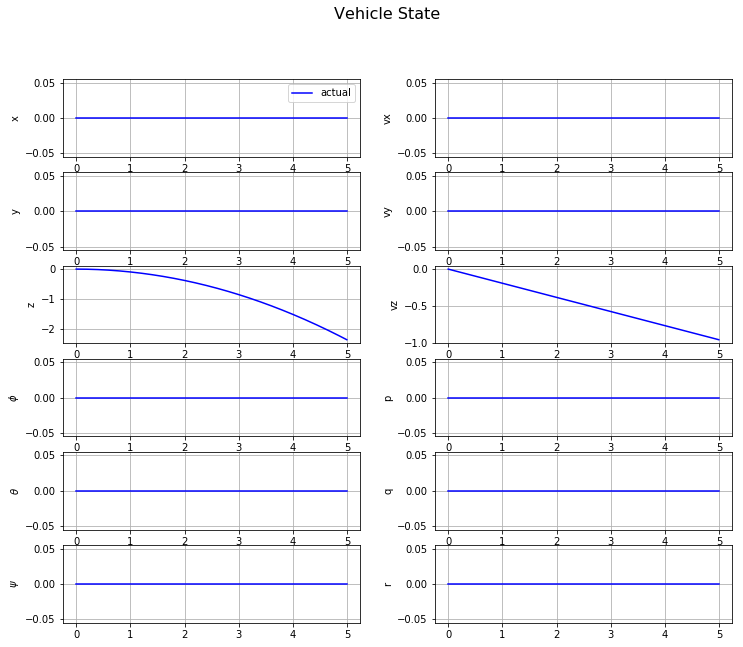

Quadrotor state after 500 iters:
	r:     [[ 0.000  0.000 -2.370]].T
	Phi:   [[ 0.000  0.000  0.000]].T
	v:     [[ 0.000  0.000 -0.950]].T
	omega: [[ 0.000  0.000  0.000]].T



In [40]:
sim = Simulator()
sim.run(5, Ts=0.01)
sim.plot()

print(sim.quad)